# Finetune Korean syllable embedding for NMSC

## Import

In [1]:
import os
import json
import csv
from tqdm import tqdm
import fasttext
from mecab import MeCab
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, accuracy_score, fbeta_score
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, use_memory_fs=True)

import utils

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Initialization

### Configuration

- `train_origin`: original NMSC train set `.txt` file
- `test_origin`: original NMSC test set `.txt` file
- `<train|val|test>_fastText`: `.txt` file where each line follows the format `__label__<label> <text>`
- `pretrained_bin`: `.bin` file of the pre-trained embeddings
- `pretrained_vec`: `.vec` file of the pre-trained embeddings

In [2]:
config = dict()
config['train_url'] = 'https://github.com/e9t/nsmc/raw/master/ratings_train.txt'
config['test_url'] = 'https://github.com/e9t/nsmc/raw/master/ratings_test.txt'
config['train_set'] = './tmp/nmsc_train.txt'
config['val_set'] = './tmp/nmsc_val.txt'
config['test_set'] = './tmp/nmsc_test.txt'
config['pretrained_bin'] = './tmp/fasttext.bin'
config['pretrained_vec'] = './tmp/fasttext.vec'

### Dataset

In [3]:
train_set =  utils.get_nmsc(config['train_url'])

In [4]:
train_set

,document,label
id,,
9976970,아 더빙.. 진짜 짜증나네요 목소리,0
3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
10265843,너무재밓었다그래서보는것을추천한다,0
9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
6222902,인간이 문제지.. 소는 뭔죄인가..,0
8549745,평점이 너무 낮아서...,1
9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0


In [5]:
train_set, val_set = train_test_split(
    train_set, 
    test_size=0.3, 
    random_state=777, 
    stratify=train_set['label']
)

In [6]:
train_set

,document,label
id,,
3546826,미스테리,0
10161639,뭐 말이 필요한가???,1
9295845,흠... 만든 이유를 모르겠음...,0
9868407,쓰래기영화 정우성 이건아닌되요,0
5374061,감각적인 영상속에 펼쳐지는 화끈한 액숀과 코믹 퍼레이드,1
...,...,...
3626259,아버지... 보물같은 영화.,1
9274666,난 진짜 뻥안치고 별로엿음...주온1편이 너무 충격적이어서..기대치를 못채운듯..,0
6594162,이거보고재밋다고한혹우잇는가?,0


In [7]:
val_set

,document,label
id,,
10175148,저렇게 근로자의 노동권이 처참히 유린당하는데.. 왜 노동자들은 화를 내지 못하는걸까?,1
2810310,정말 유쾌함에정신을 놓았다영화 아님 이런 기분 못 느껴 볼껄그만큼 존재가치도 높다,1
5407585,영화관 가서 본거는 귀썩고 나래이션 쓰래긴데 KBS에서 하고있는건 완전 신기,0
9808055,네이버 평점에 심하게 낚였다. 보는 내내 지루해서 끌까말까 망설였는데..,0
6862407,내가 알던 택시가 맞나 싶은 영화 유머코드도 전혀 나랑 매치도 안되는 것 같고 여러...,0
...,...,...
5786109,우리에게 굵직한 지혜들을 건네는 너무나 멋진 영화,1
6326336,"막장인생 바니 결국 사랑으로 구원 받고,죽음으로 용서받았다.",1
9339957,링과 더불어 일본공포물에는 가장 잼나게 본 영화. 벨소리가 상당한 공포감을 조성한다.,1


In [8]:
test_set =  utils.get_nmsc(config['test_url'])

In [9]:
test_set

,document,label
id,,
6270596,굳 ㅋ,1
9274899,GDNTOPCLASSINTHECLUB,0
8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...
4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0


### MeCab

In [10]:
mecab = MeCab()

### fastText

- Download the pre-trained fastText files from https://ratsgo.github.io/embedding/downloaddata.html

In [11]:
model = fasttext.load_model(config['pretrained_bin'])

#### E.g., ten tokens

In [12]:
model.words[:10]

['1', '.', '0', '2', '의', ',', '이', '는', '다', ')']

## Morpheme Analysis

- fastText tokenizes based on spacing by default
- But it's difficult to reflect the meaning if we tokenize Korean corpus based on spacing because Korean is belongs to an agglutinative language
- So it’s more appropriate to tokenize it based on morphemes if we’re dealing with Korean
- E.g., AP(val) w/ MeCab is 0.92 and w/o is 0.87

### Named Entity Normalization: person name

- Proper nouns are one of the parts of speech where a lot of new words appears
- E.g., person name, movie title, ...
- That's why I implemented the normalization below
- However, there is a lot of words with strong ambiguity in the person name dictionary provided by default in MeCab
- E.g., `레이디`, `가가`, ...
- So it may be more appropriate to remove the default person name dictionary and build a new one ourselves in terms of disambiguation if we can obtain a list of people names
- E.g., f1(val) w/ NEN is 0.850 and w/o is 0.852
- And `인명` may be too general to be used for normalization
- So it may be appropriate to normalize by their jobs or other characteristics

In [13]:
def normalize_person_names(x):
    morphemes = mecab.parse(x)
    result = x
    
    for idx, morpheme in enumerate(morphemes):
        if morpheme[1].semantic != '인명': continue        
        result = result.replace(
            morpheme[0], 
            '사람', 
            1
        )
        
    result = ' '.join(mecab.morphs(result))
        
    return result

def analyze(documents):
    return documents.parallel_apply(
        lambda x: normalize_person_names(x)
    )

In [14]:
train_set.insert(train_set.shape[1], 'morphemes', analyze(train_set['document']))

In [15]:
train_set

,document,label,morphemes
id,,,
3546826,미스테리,0,미스테리
10161639,뭐 말이 필요한가???,1,뭐 말 이 필요 한가 ? ??
9295845,흠... 만든 이유를 모르겠음...,0,흠 . .. 만든 이유 를 모르 겠 음 . ..
9868407,쓰래기영화 정우성 이건아닌되요,0,쓰래 사람 사람 이건 아닌 되 요
5374061,감각적인 영상속에 펼쳐지는 화끈한 액숀과 코믹 퍼레이드,1,감각 적 인 영상 속 에 펼쳐지 는 화끈 한 액 사람 과 코믹 퍼레이드
...,...,...,...
3626259,아버지... 보물같은 영화.,1,아버지 . .. 보물 같 은 영화 .
9274666,난 진짜 뻥안치고 별로엿음...주온1편이 너무 충격적이어서..기대치를 못채운듯..,0,난 진짜 뻥 안 치 고 별로 엿 음 . .. 주온 1 편 이 너무 충격 적 이 어서...
6594162,이거보고재밋다고한혹우잇는가?,0,이거 보고 재 밋 다고 한 혹우 잇 는가 ?


In [16]:
val_set.insert(val_set.shape[1], 'morphemes', analyze(val_set['document']))

In [17]:
val_set

,document,label,morphemes
id,,,
10175148,저렇게 근로자의 노동권이 처참히 유린당하는데.. 왜 노동자들은 화를 내지 못하는걸까?,1,저렇게 근로자 의 노동 권 이 처참히 유린 당하 는데 . . 왜 노동자 들 은 화 ...
2810310,정말 유쾌함에정신을 놓았다영화 아님 이런 기분 못 느껴 볼껄그만큼 존재가치도 높다,1,정말 유쾌 함 에 정신 을 놓 았 다 영화 아님 이런 기분 못 느껴 볼 껄 그만큼 ...
5407585,영화관 가서 본거는 귀썩고 나래이션 쓰래긴데 KBS에서 하고있는건 완전 신기,0,영화관 가 서 본 거 는 귀 썩 고 나래 이 션 쓰래 긴데 KBS 에서 하 고 있 ...
9808055,네이버 평점에 심하게 낚였다. 보는 내내 지루해서 끌까말까 망설였는데..,0,네이버 평점 에 심하 게 낚였 다 . 보 는 내내 지루 해서 끌 까말까 망설였 는데...
6862407,내가 알던 택시가 맞나 싶은 영화 유머코드도 전혀 나랑 매치도 안되는 것 같고 여러...,0,내 가 알 던 택시 가 맞 나 싶 은 영화 유머 코드 도 전혀 나 랑 매치 도 안 ...
...,...,...,...
5786109,우리에게 굵직한 지혜들을 건네는 너무나 멋진 영화,1,우리 에게 굵직 한 지혜 들 을 건네 는 너무나 멋진 영화
6326336,"막장인생 바니 결국 사랑으로 구원 받고,죽음으로 용서받았다.",1,"막장 인생 사람 결국 사랑 으로 구원 받 고 , 죽음 으로 용서 받 았 다 ."
9339957,링과 더불어 일본공포물에는 가장 잼나게 본 영화. 벨소리가 상당한 공포감을 조성한다.,1,링 과 더불 어 일본 공포물 에 는 가장 잼 나 게 본 영화 . 벨소리 가 상당 한...


In [18]:
test_set.insert(test_set.shape[1], 'morphemes', analyze(test_set['document']))

In [19]:
test_set

,document,label,morphemes
id,,,
6270596,굳 ㅋ,1,굳 ㅋ
9274899,GDNTOPCLASSINTHECLUB,0,GDNTOPCLASSINTHECLUB
8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,뭐 야 이 평점 들 은 . ... 나쁘 진 않 지만 10 점 짜리 는 더더욱 아니 잖아
6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,지루 하 지 는 않 은데 완전 막장 임 . .. 돈 주 고 보 기 에 는 . ...
6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,3 D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제 ...
...,...,...,...
4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,오랜만 에 평점 로 긴 했 네 ㅋㅋ 킹왕짱 쌈 뽕 한 영화 를 만났 습니다 강렬 하...
5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0,의지 박약 들 이나 하 는 거 다 탈영 은 일단 주인공 사람 닮 았 고 이등병 찐따...
9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0,그림 도 좋 고 완성도 도 높 았 지만 . .. 보 는 내내 불안 하 게 만든다


## Typecasting

In [20]:
train_set = train_set.astype({
    'document':'str',
    'label':'int',
    'morphemes':'str',
})

In [21]:
train_set

,document,label,morphemes
id,,,
3546826,미스테리,0,미스테리
10161639,뭐 말이 필요한가???,1,뭐 말 이 필요 한가 ? ??
9295845,흠... 만든 이유를 모르겠음...,0,흠 . .. 만든 이유 를 모르 겠 음 . ..
9868407,쓰래기영화 정우성 이건아닌되요,0,쓰래 사람 사람 이건 아닌 되 요
5374061,감각적인 영상속에 펼쳐지는 화끈한 액숀과 코믹 퍼레이드,1,감각 적 인 영상 속 에 펼쳐지 는 화끈 한 액 사람 과 코믹 퍼레이드
...,...,...,...
3626259,아버지... 보물같은 영화.,1,아버지 . .. 보물 같 은 영화 .
9274666,난 진짜 뻥안치고 별로엿음...주온1편이 너무 충격적이어서..기대치를 못채운듯..,0,난 진짜 뻥 안 치 고 별로 엿 음 . .. 주온 1 편 이 너무 충격 적 이 어서...
6594162,이거보고재밋다고한혹우잇는가?,0,이거 보고 재 밋 다고 한 혹우 잇 는가 ?


In [22]:
val_set = val_set.astype({
    'document':'str',
    'label':'int',
    'morphemes':'str',
})

In [23]:
val_set

,document,label,morphemes
id,,,
10175148,저렇게 근로자의 노동권이 처참히 유린당하는데.. 왜 노동자들은 화를 내지 못하는걸까?,1,저렇게 근로자 의 노동 권 이 처참히 유린 당하 는데 . . 왜 노동자 들 은 화 ...
2810310,정말 유쾌함에정신을 놓았다영화 아님 이런 기분 못 느껴 볼껄그만큼 존재가치도 높다,1,정말 유쾌 함 에 정신 을 놓 았 다 영화 아님 이런 기분 못 느껴 볼 껄 그만큼 ...
5407585,영화관 가서 본거는 귀썩고 나래이션 쓰래긴데 KBS에서 하고있는건 완전 신기,0,영화관 가 서 본 거 는 귀 썩 고 나래 이 션 쓰래 긴데 KBS 에서 하 고 있 ...
9808055,네이버 평점에 심하게 낚였다. 보는 내내 지루해서 끌까말까 망설였는데..,0,네이버 평점 에 심하 게 낚였 다 . 보 는 내내 지루 해서 끌 까말까 망설였 는데...
6862407,내가 알던 택시가 맞나 싶은 영화 유머코드도 전혀 나랑 매치도 안되는 것 같고 여러...,0,내 가 알 던 택시 가 맞 나 싶 은 영화 유머 코드 도 전혀 나 랑 매치 도 안 ...
...,...,...,...
5786109,우리에게 굵직한 지혜들을 건네는 너무나 멋진 영화,1,우리 에게 굵직 한 지혜 들 을 건네 는 너무나 멋진 영화
6326336,"막장인생 바니 결국 사랑으로 구원 받고,죽음으로 용서받았다.",1,"막장 인생 사람 결국 사랑 으로 구원 받 고 , 죽음 으로 용서 받 았 다 ."
9339957,링과 더불어 일본공포물에는 가장 잼나게 본 영화. 벨소리가 상당한 공포감을 조성한다.,1,링 과 더불 어 일본 공포물 에 는 가장 잼 나 게 본 영화 . 벨소리 가 상당 한...


In [24]:
test_set = test_set.astype({
    'document':'str',
    'label':'int',
    'morphemes':'str',
})

In [25]:
test_set

,document,label,morphemes
id,,,
6270596,굳 ㅋ,1,굳 ㅋ
9274899,GDNTOPCLASSINTHECLUB,0,GDNTOPCLASSINTHECLUB
8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,뭐 야 이 평점 들 은 . ... 나쁘 진 않 지만 10 점 짜리 는 더더욱 아니 잖아
6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,지루 하 지 는 않 은데 완전 막장 임 . .. 돈 주 고 보 기 에 는 . ...
6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,3 D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제 ...
...,...,...,...
4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,오랜만 에 평점 로 긴 했 네 ㅋㅋ 킹왕짱 쌈 뽕 한 영화 를 만났 습니다 강렬 하...
5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0,의지 박약 들 이나 하 는 거 다 탈영 은 일단 주인공 사람 닮 았 고 이등병 찐따...
9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0,그림 도 좋 고 완성도 도 높 았 지만 . .. 보 는 내내 불안 하 게 만든다


## Fine-tuning

In [26]:
def write_fasttext_dataset(dataframe, dst_path, label_map):
    results = dataframe.parallel_apply(
        lambda x: ''.join([label_map[x['label']], ' ', x['morphemes']]),
        axis=1
    )
    
    results.to_csv(dst_path, header=False, index=False)

In [27]:
label_map = dict()
label_map[0] = '__label__Bad'
label_map[1] = '__label__Good'

In [28]:
write_fasttext_dataset(train_set, config['train_set'], label_map)

In [29]:
write_fasttext_dataset(val_set, config['val_set'], label_map)

In [30]:
write_fasttext_dataset(test_set, config['test_set'], label_map)

In [31]:
model = fasttext.train_supervised(
    config['train_set'], 
    pretrainedVectors=config['pretrained_vec'],
)

Read 2M words
Number of words:  40332
Number of labels: 2
Progress: 100.0% words/sec/thread:  279182 lr:  0.000000 avg.loss:  0.382104 ETA:   0h 0m 0s


In [32]:
tqdm.pandas()

In [33]:
def predict(model, features):
    return features.progress_apply(lambda x: model.predict(x, k=2))

In [34]:
%%time
validation_results = predict(model, val_set['morphemes'])

100%|██████████| 45000/45000 [00:00<00:00, 86126.56it/s]

CPU times: user 534 ms, sys: 13.1 ms, total: 547 ms
Wall time: 543 ms


In [35]:
validation_results

id
10175148    ((__label__Bad, __label__Good), [0.93265974521...
2810310     ((__label__Bad, __label__Good), [0.58815407752...
5407585     ((__label__Bad, __label__Good), [0.84095680713...
9808055     ((__label__Bad, __label__Good), [0.99599111080...
6862407     ((__label__Bad, __label__Good), [0.94865900278...
                                  ...                        
5786109     ((__label__Good, __label__Bad), [0.98361921310...
6326336     ((__label__Good, __label__Bad), [0.80302095413...
9339957     ((__label__Good, __label__Bad), [0.55809128284...
8038339     ((__label__Bad, __label__Good), [0.85647469758...
3276814     ((__label__Good, __label__Bad), [0.61999642848...
Name: morphemes, Length: 45000, dtype: object

In [36]:
# model.save_model("model_filename.bin")

## Validation

### P@1, R@1

- Do not use if the task is not multi-label classification

In [37]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test(config['val_set']))

N	40729
P@1	0.848
R@1	0.848


### precision-recall curve

In [38]:
def plot_precision_recall_curve(model, dataset):
    labels = dataset['label'].astype('int')
    preds = dataset.progress_apply(lambda x: model.predict(x['morphemes'], k=2), axis=1)
    preds = preds.apply(lambda x: np.array(x[1])[np.argsort(x[0])][1])
    PrecisionRecallDisplay.from_predictions(labels, preds)

100%|██████████| 45000/45000 [00:01<00:00, 44790.02it/s]


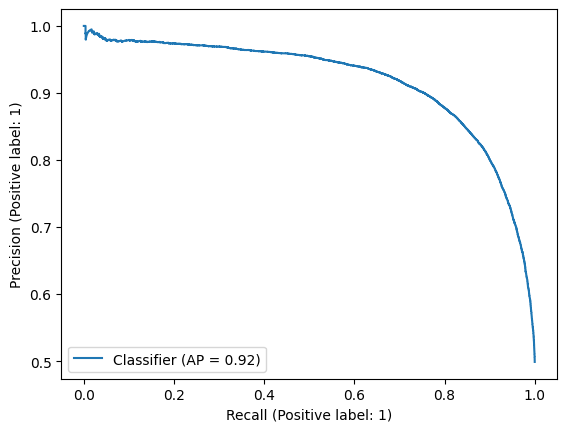

In [39]:
plot_precision_recall_curve(model, val_set)

In [40]:
def get_precision_recall_curve(model, dataset):
    labels = dataset['label'].astype('int')
    preds = dataset.progress_apply(lambda x: model.predict(x['morphemes'], k=2), axis=1)
    preds = preds.apply(lambda x: np.array(x[1])[np.argsort(x[0])][1])
    return precision_recall_curve(labels, preds)

In [41]:
metrics = dict()
metrics['precision'], metrics['recall'], metrics['threshold'] = get_precision_recall_curve(model, val_set)

100%|██████████| 45000/45000 [00:00<00:00, 46969.98it/s]


### Finding an optimal threshold based on f1-score

In [42]:
def get_fbeta_score(precision, recall, beta=1):
    coefficient = (1 + beta**2)
    numerator = precision * recall
    denominator = ((beta**2) * precision) + recall
    return coefficient * (numerator/denominator)

In [43]:
f1_scores = get_fbeta_score(metrics['precision'], metrics['recall'])
best_threshold = metrics['threshold'][f1_scores.argmax()]
best_precision = metrics['precision'][f1_scores.argmax()]
best_recall = metrics['recall'][f1_scores.argmax()]

In [44]:
f1_scores.max()

0.8505915250591525

In [45]:
f1_scores.argmax()

20508

In [46]:
best_threshold

0.4161111116409302

In [47]:
best_precision

0.8223941435820648

In [48]:
best_recall

0.8807911617961511